In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2 
import glob
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
images_path = tf.io.gfile.glob("GGDataSet/GGDataSet/train_frames/train/*") #glob.glob
labels_path = tf.io.gfile.glob("GGDataSet/GGDataSet/train_masks/train/*")

In [3]:
len(images_path)

6440

In [4]:
len(labels_path), labels_path[0]

(6440, 'GGDataSet\\GGDataSet\\train_masks\\train\\train_00000.png')

[  0  38 147]


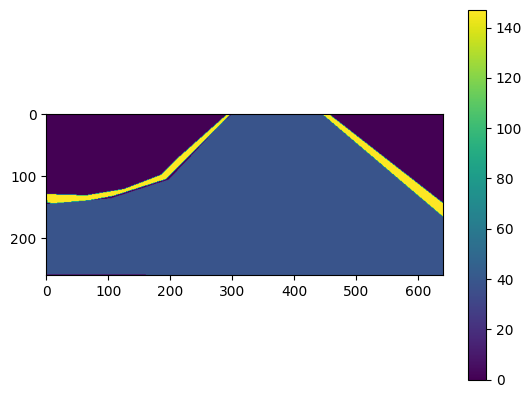

In [5]:
image = cv2.imread(labels_path[0], 0)
# image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
print(np.unique(image))
plt.imshow(image)
plt.colorbar()
plt.show()

In [6]:
labels_path[0]

'GGDataSet\\GGDataSet\\train_masks\\train\\train_00000.png'

In [7]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
import tensorflow as tf
def load_image_and_labels(images_path, labels_path):
    image = tf.io.read_file(images_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [128, 128]) / 255.0

    label = tf.io.read_file(labels_path)
    label = tf.image.decode_jpeg(label, channels=1)
    label = tf.image.resize(label, [128, 128], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.cast(label, tf.float32)

    new_label = tf.where(tf.equal(label, 38.), 1., label)  
    new_label = tf.where(tf.equal(label, 147.), 2., new_label) 

    label = tf.cast(new_label, tf.int32)
    cat = tf.one_hot(label, depth=3)
    label = tf.reshape(cat, (label.shape[0], label.shape[1], 3))
    label = tf.cast(label, tf.float32)

    return image, label

images_path_1 = images_path[0]
labels_path_1 = labels_path[0]
image, label = load_image_and_labels(images_path_1, labels_path_1)

In [9]:
label.shape

TensorShape([128, 128, 3])

In [10]:
image.shape

TensorShape([128, 128, 3])

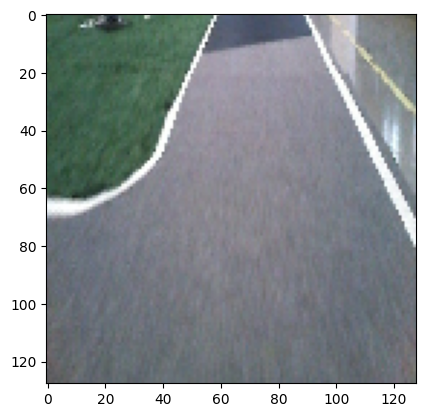

(128, 128)
[0. 1.]


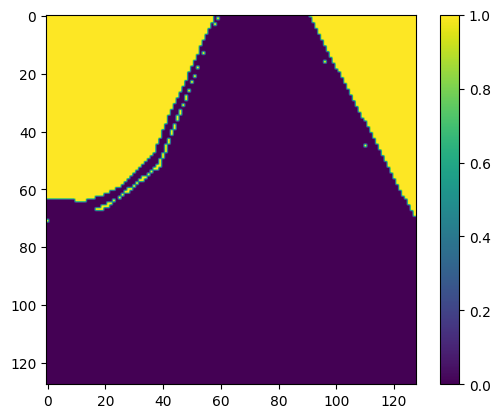

(128, 128)
[0. 1.]


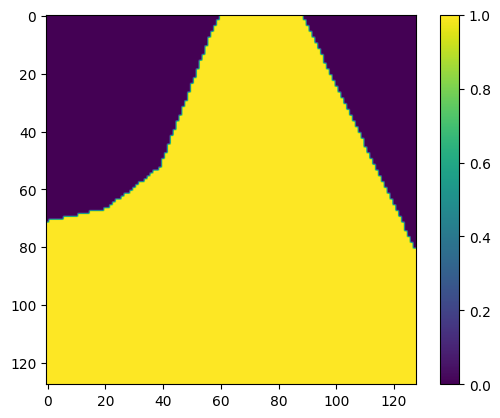

(128, 128)
[0. 1.]


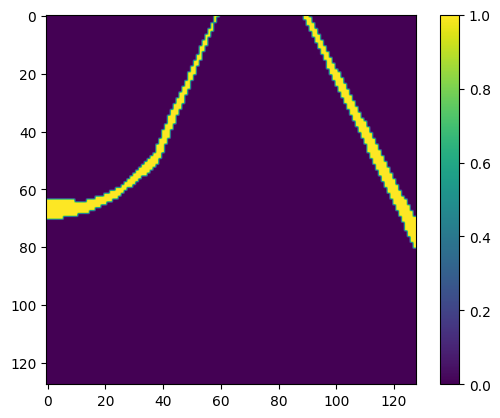

(128, 128, 3)
[0. 1.]


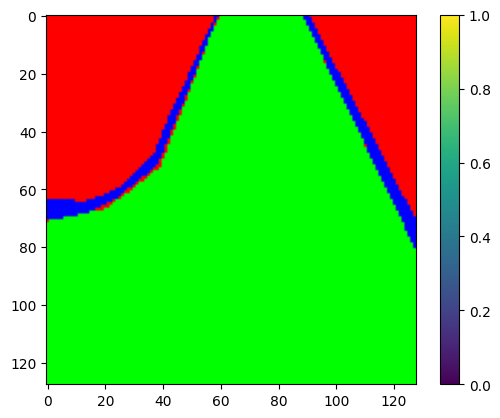

In [11]:

plt.imshow(image)
plt.show()
print("===============================================================")
print(label[:,:, 0].shape)
print(np.unique(label[:,:, 0]))
plt.imshow(label[:,:, 0])
plt.colorbar()
plt.show()
print("===============================================================")
print(label[:,:, 1].shape)
print(np.unique(label[:,:, 1]))
plt.imshow(label[:,:, 1])
plt.colorbar()
plt.show()
print("===============================================================")
print(label[:,:, 2].shape)
print(np.unique(label[:,:, 2]))
plt.imshow(label[:,:, 2])
plt.colorbar()
plt.show()
print("===============================================================")
print(label[:,:, :].shape)
print(np.unique(label[:,:, :]))
plt.imshow(label[:,:, :])
plt.colorbar()
plt.show()
    

In [12]:
def load_image_and_labels(images_path, labels_path):
    image = tf.io.read_file(images_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [128, 128]) / 255.0

    label = tf.io.read_file(labels_path)
    label = tf.image.decode_jpeg(label, channels=1)
    label = tf.image.resize(label, [128, 128], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.cast(label, tf.float32)

    new_label = tf.where(tf.equal(label, 38.), 1., label)  
    new_label = tf.where(tf.equal(label, 147.), 2., new_label) 

    label = tf.cast(new_label, tf.int32)
    cat = tf.one_hot(label, depth=3)
    label = tf.reshape(cat, (label.shape[0], label.shape[1], 3))
    label = tf.cast(label, tf.float32)

    return image, label

dataset = tf.data.Dataset.from_tensor_slices((images_path, labels_path))
dataset = dataset.map(load_image_and_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)
batch_size = 8
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


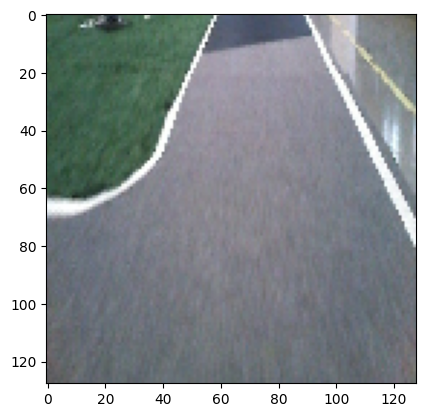

(128, 128)
[0. 1.]


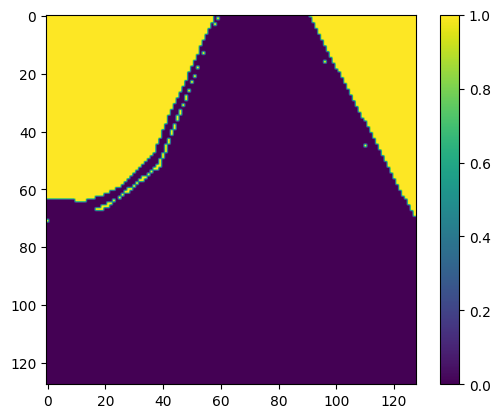

(128, 128)
[0. 1.]


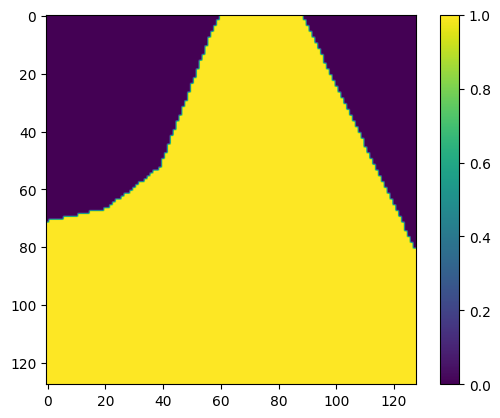

In [13]:
for img, lb in train_dataset.take(1):
    plt.imshow(img[0])
    plt.show()
    print("===============================================================")
    print(lb[0][:,:,0].shape)
    print(np.unique(lb[0][:,:,0]))
    plt.imshow(lb[0][:,:,0])
    plt.colorbar()
    plt.show()
    print("===============================================================")
    print(lb[0][:,:,1].shape)
    print(np.unique(lb[0][:,:,1]))
    plt.imshow(lb[0][:,:,1])
    plt.colorbar()
    plt.show()
    

In [14]:
model = tf.keras.models.load_model("model/resnet_unet.keras", compile = False)

In [15]:
import keras.backend as K
from keras.losses import binary_crossentropy

def dice_coefficients(y_true, y_pred, smooth = 1):
    y_true = K.cast(y_true, tf.float32)
    y_pred = K.cast(y_pred, tf.float32)
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2. * intersection + smooth) / (union + smooth)

def dice_coefficients_loss(y_true, y_pred, smooth = 1):
    return 1 -dice_coefficients(y_true, y_pred, smooth)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coefficients_loss(y_true, y_pred)



In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.001),
    loss=bce_dice_loss, metrics=["accuracy",  dice_coefficients])

In [22]:
model.fit(train_dataset, validation_data= val_dataset, epochs=20, verbose= True)

Epoch 1/20
644/644 [==============================] - 156s 243ms/step - loss: 0.1239 - accuracy: 0.9617 - dice_coefficients: 0.9583 - val_loss: 0.6475 - val_accuracy: 0.8589 - val_dice_coefficients: 0.8543
Epoch 2/20
644/644 [==============================] - 148s 229ms/step - loss: 0.1195 - accuracy: 0.9639 - dice_coefficients: 0.9606 - val_loss: 0.5036 - val_accuracy: 0.9048 - val_dice_coefficients: 0.8997
Epoch 3/20
644/644 [==============================] - 162s 251ms/step - loss: 0.1077 - accuracy: 0.9664 - dice_coefficients: 0.9638 - val_loss: 1.4376 - val_accuracy: 0.6198 - val_dice_coefficients: 0.6208
Epoch 4/20
644/644 [==============================] - 153s 237ms/step - loss: 0.0978 - accuracy: 0.9703 - dice_coefficients: 0.9678 - val_loss: 1.1622 - val_accuracy: 0.6250 - val_dice_coefficients: 0.6248
Epoch 5/20
644/644 [==============================] - 151s 235ms/step - loss: 0.0967 - accuracy: 0.9703 - dice_coefficients: 0.9679 - val_loss: 0.3243 - val_accuracy: 0.8941 - 

In [23]:
model.save("model/resnet_unet.h5")
model.save("model/resnet_unet.keras")

1/1 [==============================] - 0s 32ms/step
[1.0420472e-15 1.1339744e-15 1.1966196e-15 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[3.8986605e-09 4.0393626e-09 4.1879131e-09 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


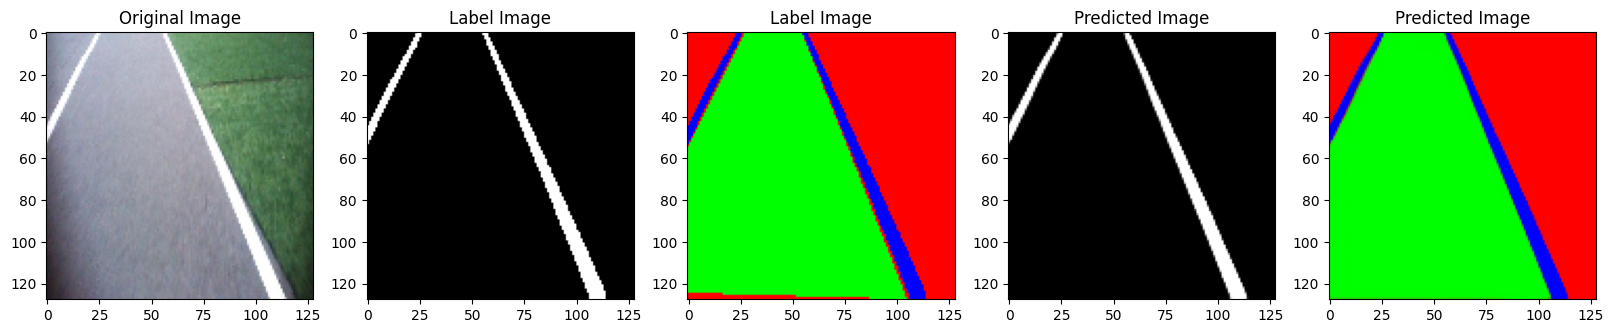

1/1 [==============================] - 0s 33ms/step
[9.9927166e-16 1.7110015e-15 1.7225801e-15 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[1.3507317e-10 1.7033149e-10 1.9790970e-10 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


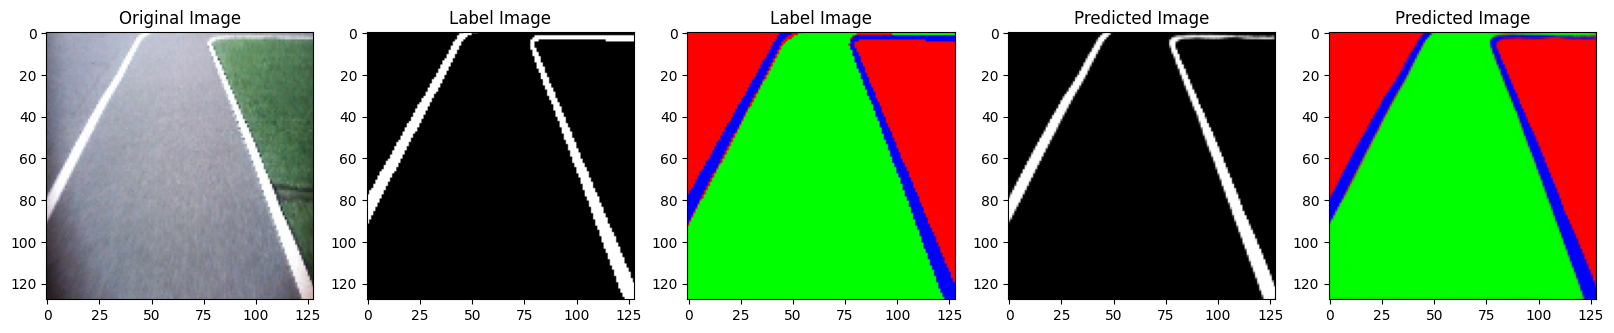

1/1 [==============================] - 0s 19ms/step
[1.7382557e-17 2.2194920e-17 2.6627860e-17 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[1.2982151e-11 1.3728999e-11 1.4426421e-11 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


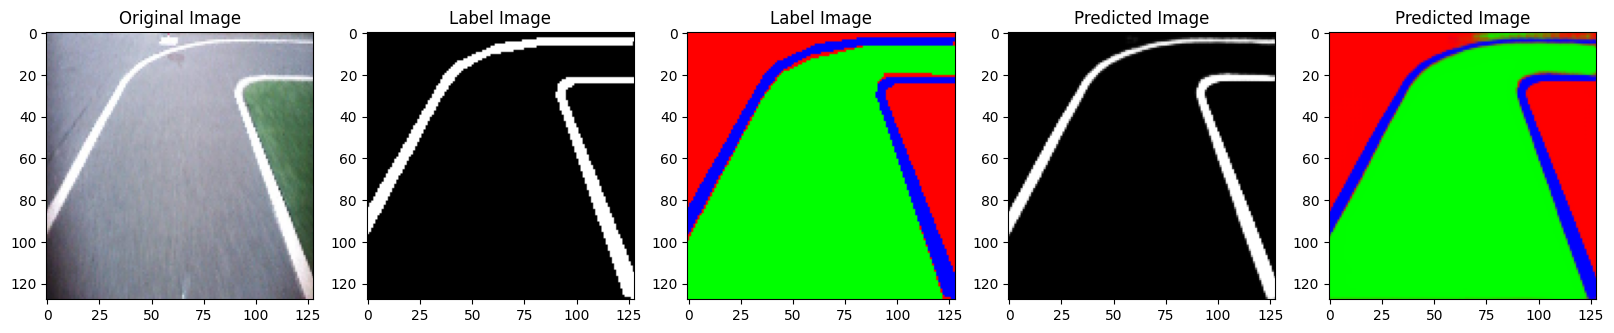

1/1 [==============================] - 0s 34ms/step
[6.5080544e-35 6.7833302e-35 9.0001059e-35 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[1.7326536e-11 2.5612627e-11 2.7761548e-11 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


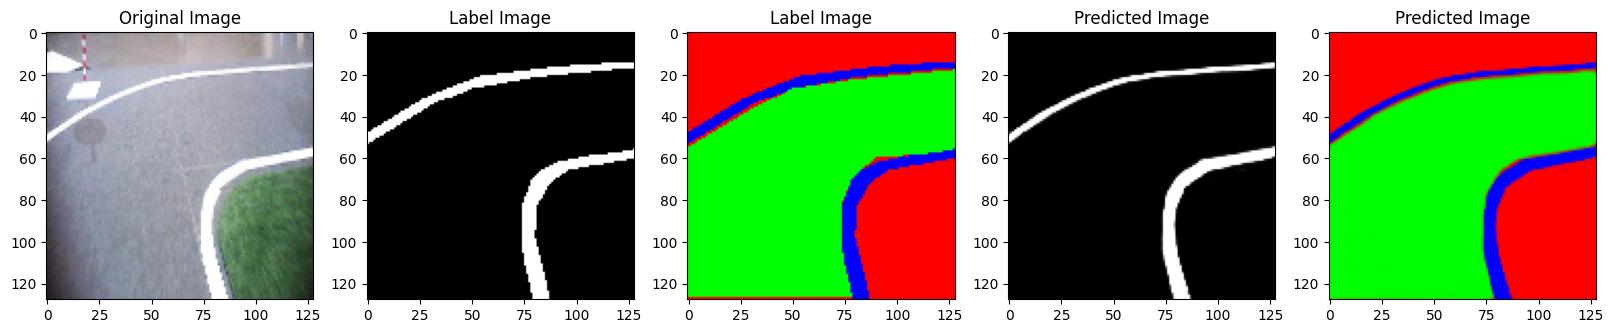

1/1 [==============================] - 0s 26ms/step
[1.8861184e-16 3.7884115e-16 4.0105901e-16 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[1.4363593e-12 1.6998014e-12 1.7725914e-12 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]


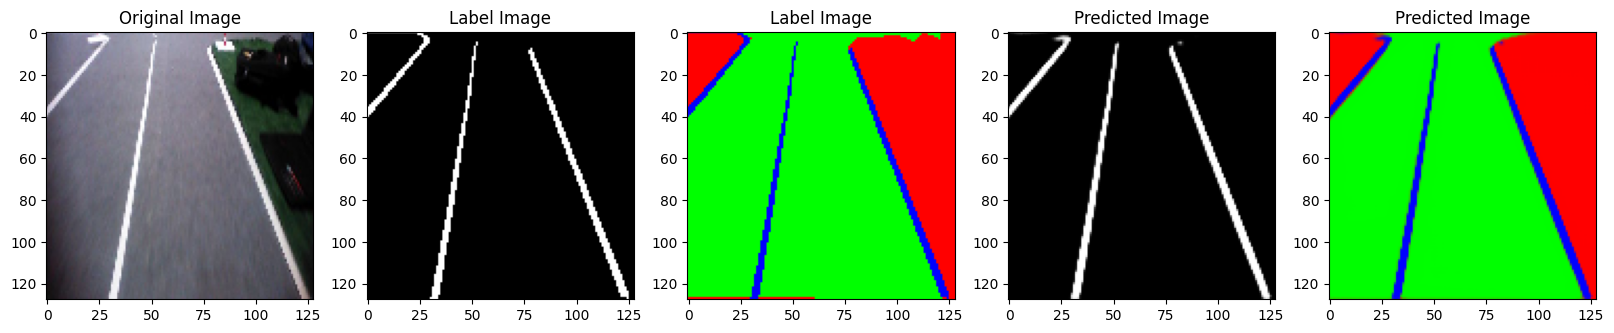

In [24]:
for img, lb in val_dataset.take(5):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    y_pred = model.predict(np.expand_dims(img[0], axis = 0))
    axes[0].imshow(img[0])
    axes[0].set_title("Original Image")

    axes[1].imshow(lb[0][:,:,2], cmap ="gray")
    axes[1].set_title("Label Image")

    axes[2].imshow(lb[0][:,:,:], cmap ="gray")
    axes[2].set_title("Label Image")

    axes[3].imshow(y_pred[0][:,:,2], cmap ="gray")
    print(np.unique(y_pred[0][:,:,0]))
    axes[3].set_title("Predicted Image")

    axes[4].imshow(y_pred[0][:,:,:], cmap ="gray")
    print(np.unique(y_pred[0][:,:,1]))
    axes[4].set_title("Predicted Image")

    plt.show()
    print("===============================================================")


In [39]:
import cv2
import time
import numpy as np

cap = cv2.VideoCapture('road.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width, frame_height = cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

output_width, output_height = 128, 128
# Pre-allocate memory 
resized_frame = np.zeros((output_height, output_width, 3), dtype=np.uint8)
normalized_frame = np.zeros((1, output_height, output_width, 3), dtype=np.float32)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_video.mp4', fourcc, fps, (output_width, output_height))

start_time = time.time()
frame_count = 0

while True:
    ret, frame = cap.read()

    if not ret:
        break

    resized_frame = cv2.resize(frame, (output_width, output_height))
    normalized_frame[0] = resized_frame / 255.0
    prediction = model.predict(normalized_frame)[0]
    img_array = prediction * 255
    prediction_vis = img_array.astype(np.uint8)

    out.write(prediction_vis)

    cv2.imshow('Frame', resized_frame)
    cv2.imshow('Prediction', prediction_vis)

    frame_count += 1
    current_time = time.time()
    elapsed_time = current_time - start_time
    if elapsed_time > 1:
        fps_prediction = frame_count / elapsed_time
        print("Prediction FPS:", fps_prediction)
        frame_count = 0
        start_time = time.time()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 34ms/step
Prediction FPS: 9.655289260155504
1/1 [==============================] - 0s 29ms/step
Prediction FPS: 11.94678782174148
1/1 [==============================] - 0s 18ms/step
Prediction FPS: 12.691935727902685
1/1 [==============================] - 0s 16ms/step
Prediction FPS: 14.06591205272535
1/1 [==============================] - 0s 31ms/step
Prediction FPS: 12.755682817734359
1/1 [==============================] - 0s 20ms/step
Prediction FPS: 10.660034606673142
1/1 [==============================] - 0s 51ms/step
Prediction FPS: 10.151780272375579
1/1 [==============================] - 0s 15ms/step
Prediction FPS: 9.403396186990713
1/1 [==============================] - 0s 15ms/step
Prediction FPS: 10.589627397636317
1/1 [==============================] - 0s 32ms/step
Prediction FPS: 11.262214616367784
1/1 [==============================] - 0s 31ms/step
Prediction FPS: 11.813044102777864
1/1 [==============================] - 0s 36ms/